In [1]:
from threading import Thread

In [2]:
class Worker(Thread):
    'computes x, v and a of the ith body'
    def __init__(self, *args, **kwargs):
        super(Worker, self).__init__(*args, **kwargs)
        self.inputs =[]
        self.results = []
        self.running = True
        self.daemon = True
        self.start()

    def run(self):
        while self.running:
            if len(self.inputs) == 0:
                continue
            i, x0, v0, G, m, dt = self.inputs.pop(0)
            a_i0 = a(i, x0, G, m)
            v_i1 = a_i0 * dt + v0[i]
            x_i1 = a_i0 * dt ** 2 + v0[i] * dt + x0[i]
            result = (i, x_i1, v_i1)
            self.results.append(result)

In [3]:
def remove_i(x, i):
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

def a(i, x, G, m):
    'the accerleration of the ith mass'
    x_i = x[i]
    x_j = remove_i(x, i)
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
    return result
    
def initial_cond(N, D):
    x0 = np.random.rand(N, D)
    v0 = np.zeros((N,D), dtype=float)
    m = np.ones(N, dtype=float)
    return x0, v0, m
        

In [4]:
class Pool(object):
    """A collection of P worker threads that distributes tasks evenly across them. """ 
    def __init__(self, size): 
        self.size = size 
        self.workers = [Worker() for p in range(size)]  
    
    def do(self, tasks): 
        for p in range(self.size): 
            self.workers[p].inputs += tasks[p::self.size] 
        while any([len(worker.inputs) != 0 for worker in self.workers]): 
            pass 
        results = [] 
        for worker in self.workers: 
            results += worker.results 
            worker.results.clear() 
            return results  
        
    def __del__(self): 
        for worker in self.workers: 
            worker.running = False

In [4]:
def timestep(x0, v0, G, m, dt, pool): 
    """Computes the next position and velocity for all masses given initial conditions and a time step size. """ 
    N = len(x0) 
    tasks = [(i, x0, v0, G, m, dt) for i in range(N)] 
    results = pool.do(tasks) 
    x1 = np.empty(x0.shape, dtype=float) 
    v1 = np.empty(v0.shape, dtype=float) 
    for i, x_i1, v_i1 in results: 
        x1[i] = x_i1 
        v1[i] = v_i1 
    return x1, v1

In [5]:
def simulate(P, N, D, S, G, dt): 
    x0, v0, m = initial_cond(N, D) 
    pool = Pool(P) 
    for s in range(S): 
        x1, v1 = timestep(x0, v0, G, m, dt, pool) 
        x0, v0 = x1, v1

In [19]:
import time
import numpy as np
Ps = [1, 2, 4, 8] 
runtimes = [] 
for P in Ps:  
    start = time.time() 
    simulate(P, 64, 3, 10, 1.0, 1e-3) 
    stop = time.time() 
    runtimes.append(stop - start)

/var/folders/tr/tw5r1fms33xbc_d62jdwbgqh0000gn/T/ipykernel_58807/1168059517.py:15: RuntimeWarning: divide by zero encountered in divide
  result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
/var/folders/tr/tw5r1fms33xbc_d62jdwbgqh0000gn/T/ipykernel_58807/1168059517.py:15: RuntimeWarning: invalid value encountered in multiply
  result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
/var/folders/tr/tw5r1fms33xbc_d62jdwbgqh0000gn/T/ipykernel_58807/1168059517.py:14: RuntimeWarning: overflow encountered in square
  mag3 = np.sum(diff**2, axis=1)**1.5
/var/folders/tr/tw5r1fms33xbc_d62jdwbgqh0000gn/T/ipykernel_58807/1168059517.py:14: RuntimeWarning: overflow encountered in power
  mag3 = np.sum(diff**2, axis=1)**1.5


Text(0, 0.5, 'Time, t1/tp ')

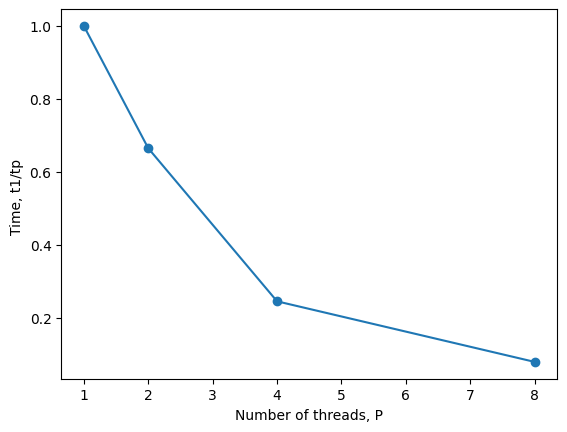

In [26]:
import matplotlib.pyplot as plt

t_s = []
for i in range(len(Ps)):
    time1 =   runtimes[0]/runtimes[i] 
    t_s.append(time1)

plt.plot(Ps, t_s, marker='o')
plt.xlabel('Number of threads, P')
plt.ylabel('Time, t1/tp ')

Text(0, 0.5, 'Time, s')

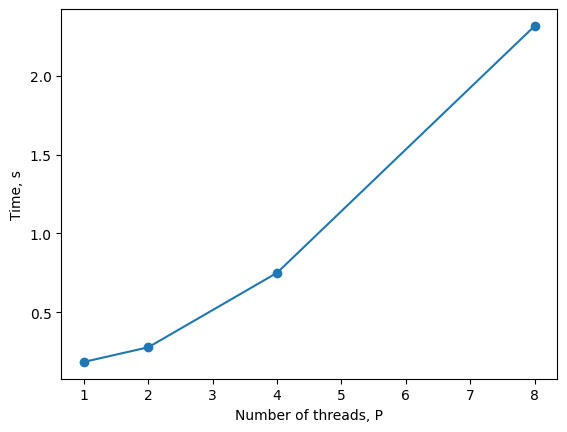

In [25]:
plt.plot(Ps, runtimes, marker='o')
plt.xlabel('Number of threads, P')
plt.ylabel('Time, s')

In [11]:
from multiprocessing import Pool 

def timestep_i(args): 
    """Computes the next position and velocity for the ith mass.""" 
    i, x0, v0, G, m, dt = args 
    a_i0 = a(i, x0, G, m) 
    v_i1 = a_i0 * dt + v0[i] 
    x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i] 
    return i, x_i1, v_i1

In [12]:
def timestep(x0, v0, G, m, dt, pool):
    N = len(x0) 
    tasks = [(i, x0, v0, G, m, dt) for i in range(N)] 
    results = pool.map(timestep_i, tasks) 
    x1 = np.empty(x0.shape, dtype=float) 
    v1 = np.empty(v0.shape, dtype=float) 
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1 
        v1[i] = v_i1 
    return x1, v1

In [ ]:
import time  
import numpy as np
Ps = [1, 2, 4, 8] 
runtimes = [] 
for P in Ps:  
    start = time.time() 
    simulate(P, 64, 3, 10, 1.0, 1e-3) 
    stop = time.time() 
    runtimes.append(stop - start)

Process SpawnPoolWorker-7:
Traceback (most recent call last):
  File "/Users/yanjun/Documents/apps/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/yanjun/Documents/apps/miniconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yanjun/Documents/apps/miniconda3/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/yanjun/Documents/apps/miniconda3/lib/python3.12/multiprocessing/queues.py", line 389, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'timestep_i' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Process SpawnPoolWorker-8:
Traceback (most recent call last):
  File "/Users/yanjun/Documents/apps/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users

In [ ]:
import matplotlib.pyplot as plt

t_s = []
for i in range(len(Ps)):
    time1 =   runtimes[0]/runtimes[i] 
    t_s.append(time1)

plt.plot(Ps, t_s, marker='o')
plt.xlabel('Number of threads, P')
plt.ylabel('Time, t1/tp ')